In [1]:
import Algos
#from Algos import ANN as t
#from Algos import PolynomialFeatures as t
#from Algos import RandomForest as t
#from Algos import RNN as t
#from Algos import CausalDiscovery as t
from Algos import TCN as t


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

2025-05-19 20:13:22.862856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 20:13:22.871784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 20:13:22.881233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-19 20:13:22.883901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 20:13:22.891244: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Read the time series data for a specific building (Building_1) from a CSV file using pandas' read_csv function.
# The file likely contains information such as electricity consumption, production, or related metrics for Building 1.
#TODO BETTER COMMENTS
building1_filepath="citylearn_challenge_2023_phase_1/Building_1.csv"
building2_filepath="citylearn_challenge_2023_phase_1/Building_2.csv"
building3_filepath="citylearn_challenge_2023_phase_1/Building_3.csv"


electricity_data = pd.read_csv(building1_filepath)
carbon_data = pd.read_csv("citylearn_challenge_2023_phase_1/carbon_intensity.csv")
pricing_data = pd.read_csv("citylearn_challenge_2023_phase_1/pricing.csv")
weather_data = pd.read_csv("citylearn_challenge_2023_phase_1/weather.csv")

dataframe = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)


#print(dataframe)

target = 'cooling_demand'
#target = 'solar_generation'

features = ['month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 
            'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 
            'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 
            'electricity_pricing_predicted_24h', 'outdoor_dry_bulb_temperature', 
            'outdoor_relative_humidity', 'diffuse_solar_irradiance', 
            'direct_solar_irradiance', 'outdoor_dry_bulb_temperature_predicted_6h', 
            'outdoor_dry_bulb_temperature_predicted_12h', 
            'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 
            'outdoor_relative_humidity_predicted_12h', 
            'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 
            'diffuse_solar_irradiance_predicted_12h', 
            'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 
            'direct_solar_irradiance_predicted_12h', 
            'direct_solar_irradiance_predicted_24h']


In [3]:
seed = 7
keras.utils.set_random_seed(seed)
    
#"parameters"
number_of_entries=-1
filters=64
kernel_size=3
WINDOW_SIZE=168
FORECAST_HORIZON=24
dense_size=50
#end "parameters"
    
#use crete_sliding_window
X, y = t.create_sliding_windows(dataframe[target].values, WINDOW_SIZE, FORECAST_HORIZON,number_of_entries)

# Split into train and test sets
X_train, X_test, y_train, y_test = t.split_train_test(X, y, 0.2)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Further split the training set into training and validation sets.
# 80% of the training data is used for training, and 20% is used for validation.
# This helps in tuning hyperparameters and assessing model performance during training.
X_train, X_val, y_train, y_val = t.split_train_test(X_train, y_train, 0.2)

model = t.create_TCN_model(dense_size, filters, kernel_size,WINDOW_SIZE)

model,history = t.Train_TCN_model(X_train,y_train,X_val,y_val,model)

real = y_test
pred = t.Predict_TCN_model(model,X_test)

/home/enrico/anaconda3/envs/Casual/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747678404.153741   76508 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747678404.169200   76508 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747678404.171296  

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


filter =  64
kernel_size =  3
window size =  168
forecast horizon =  24
dense size =  50


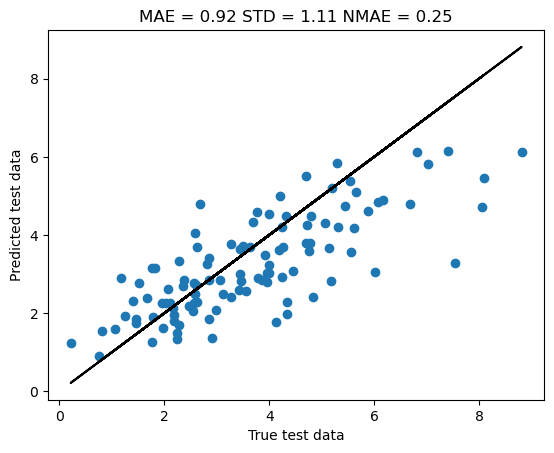

In [4]:
# Plot a scatter plot of the true test data against the predicted values.
# - The scatter plot shows the relationship between the actual values and the predicted values.
# - The title of the plot displays the Mean Absolute Error (MAE), the Standard Deviation (STD) and the Normalized Mean Absolute Error.
print("filter = ",filters)
print("kernel_size = ",kernel_size)
print("window size = ",WINDOW_SIZE)
print("forecast horizon = ",FORECAST_HORIZON)
print("dense size = ",dense_size)
plt.scatter(real, pred)
plt.title(r"MAE = %.2f" % (mean_absolute_error(real,pred)) + r" STD = %.2f" % np.std(real-pred)+ r" NMAE = %.2f" % (mean_absolute_error(real,pred)/np.mean(real)))

# Plot a reference line where predicted values equal true values (y = x).
# This line helps to visualize how well the predicted values match the true values.
plt.plot(real, real, 'k-')

# Label the x-axis as 'True test data' and the y-axis as 'Predicted test data'.
plt.xlabel('True test data')
plt.ylabel('Predicted test data')

# Display the plot to the user.
plt.show()



In [5]:
electricity_data2 = pd.read_csv(building2_filepath)
dataframe2 = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)
X, y = t.create_sliding_windows(dataframe[target].values, WINDOW_SIZE, FORECAST_HORIZON,number_of_entries)

# Split into train and test sets
X_train, X_test, y_train, y_test = t.split_train_test(X, y, 0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
                                
pred = t.Predict_TCN_model(model,X_test)
real=y_test

                                

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


filter =  64
kernel_size =  3
window size =  168
forecast horizon =  24
dense size =  50


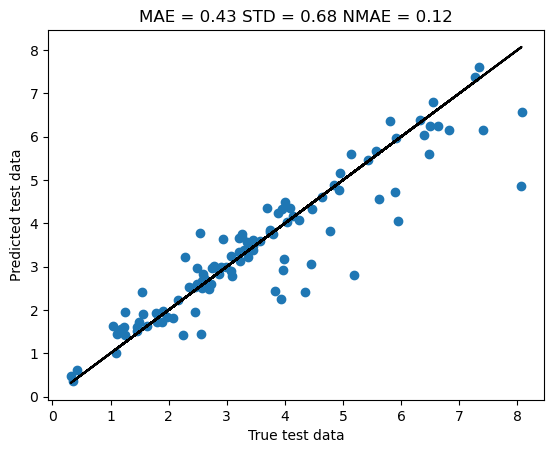

In [6]:
# Plot a scatter plot of the true test data against the predicted values.
# - The scatter plot shows the relationship between the actual values and the predicted values.
# - The title of the plot displays the Mean Absolute Error (MAE), the Standard Deviation (STD) and the Normalized Mean Absolute Error.
print("filter = ",filters)
print("kernel_size = ",kernel_size)
print("window size = ",WINDOW_SIZE)
print("forecast horizon = ",FORECAST_HORIZON)
print("dense size = ",dense_size)
plt.scatter(real, pred)
plt.title(r"MAE = %.2f" % (mean_absolute_error(real,pred)) + r" STD = %.2f" % np.std(real-pred)+ r" NMAE = %.2f" % (mean_absolute_error(real,pred)/np.mean(real)))

# Plot a reference line where predicted values equal true values (y = x).
# This line helps to visualize how well the predicted values match the true values.
plt.plot(real, real, 'k-')

# Label the x-axis as 'True test data' and the y-axis as 'Predicted test data'.
plt.xlabel('True test data')
plt.ylabel('Predicted test data')

# Display the plot to the user.
plt.show()